---
# Import Libraries

In [1]:
import os
import csv
import math
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sn
import pandas as pd

from sklearn.metrics import auc, roc_curve, confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

from collections import Counter

tf.config.experimental_run_functions_eagerly(True)
%matplotlib inline

In [2]:
def read_csv(file):
    x, y = [], []
    with open(file, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for row in spamreader:
            x.append(row[0])
            y.append(int(row[1]))
    return x, y

x_train_name, y_train = read_csv('split/train.csv')
x_val_name, y_val = read_csv('split/val.csv')
x_test_name, y_test = read_csv('split/test.csv')
x_train_name, y_train = zip(*sorted(zip(x_train_name, y_train)))
x_val_name, y_val = zip(*sorted(zip(x_val_name, y_val)))
x_test_name, y_test = zip(*sorted(zip(x_test_name, y_test)))

---
# Read and Normalize Images

In [4]:
def read_data(x, y, folder_path='inbreast_preprocessed/'):
    x_img = []
    for root, dirs, files in os.walk(folder_path, topdown=True):
        for name in sorted(files):
            if (name.endswith('.png') and name[:-4] in x):
                pth = os.path.join(root, name)
                img = cv2.imread(pth)
                img = cv2.resize(img, (550, 1170), interpolation = cv2.INTER_LANCZOS4)
                x_img.append(img)
    return np.asarray(x_img), np.asarray(y)

In [5]:
x_train, y_train = read_data(x_train_name, y_train)
x_val, y_val = read_data(x_val_name, y_val)
x_test, y_test = read_data(x_test_name, y_test)

print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({0: 222, 1: 70})
Counter({0: 40, 1: 14})
Counter({0: 48, 1: 16})


In [6]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
mean = np.mean(x_train)
std = np.std(x_train)
print(mean)
print(std)

100.090965
64.16994


In [7]:
x_train = (x_train - mean) / std
x_val = (x_val - mean) / std
x_test = (x_test - mean) / std

---
# Classification Model

## Load Patch Model

In [26]:
def build_model(input_shape = (1170, 550, 3), weights = None):
    
    # model = tf.keras.applications.vgg16.VGG16(weights = weights, include_top = False, input_shape = input_shape)
    # model = tf.keras.applications.vgg19.VGG19(weights = weights, include_top = False, input_shape = input_shape)
    # model = tf.keras.applications.inception_v3.InceptionV3(weights = weights, include_top = False, input_shape = input_shape)
    # model = tf.keras.applications.resnet_v2.ResNet50V2(weights = weights, include_top = False, input_shape = input_shape)
    model = tf.keras.applications.resnet_v2.ResNet101V2(weights = weights, include_top = False, input_shape = input_shape)

    # Top layers
    x = model.layers[-1].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(1, activation = 'sigmoid')(x)

    whole_model = Model(inputs = model.input, outputs = predictions)
  
    return whole_model

In [27]:
whole_model = build_model()

In [13]:
whole_model.load_weights('models/resnet101v2_patch.h5')

## Model Visualization

In [28]:
whole_model.summary()

relu[0][0]       
__________________________________________________________________________________________________
conv4_block18_out (Add)         (None, 74, 35, 1024) 0           conv4_block17_out[0][0]          
                                                                 conv4_block18_3_conv[0][0]       
__________________________________________________________________________________________________
conv4_block19_preact_bn (BatchN (None, 74, 35, 1024) 4096        conv4_block18_out[0][0]          
__________________________________________________________________________________________________
conv4_block19_preact_relu (Acti (None, 74, 35, 1024) 0           conv4_block19_preact_bn[0][0]    
__________________________________________________________________________________________________
conv4_block19_1_conv (Conv2D)   (None, 74, 35, 256)  262144      conv4_block19_preact_relu[0][0]  
___________________________________________________________________________________________

## Compile Model

In [14]:
whole_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
    metrics = ['accuracy', tf.keras.metrics.AUC(name = 'auc')]
)

## Data Augmentation

In [15]:
datagen = ImageDataGenerator(horizontal_flip = True)

## Callbacks

In [16]:
early_stopping = EarlyStopping(monitor = 'val_auc', patience = 3, mode = 'max')

model_checkpoint = ModelCheckpoint(filepath = 'checkpoint.h5', 
                               monitor = 'val_auc',
                               mode = 'max',
                               save_best_only = True,
                               verbose = 1
                              )

## Class Weights

In [17]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.6576576576576577, 1: 2.085714285714286}


## Train the Model

In [14]:
batch_size = 4
epochs = 50

augmented_train = datagen.flow(
    x_train, y_train, batch_size
)

whole_model.fit(
    augmented_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    class_weight = class_weights,
    callbacks = [early_stopping, model_checkpoint],
    verbose = 2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 73 steps, validate on 54 samples
Epoch 1/50

Epoch 00001: val_auc improved from -inf to 0.87143, saving model to checkpoint.h5
73/73 - 98s - loss: 0.5085 - accuracy: 0.8288 - auc: 0.8597 - val_loss: 1.6523 - val_accuracy: 0.7593 - val_auc: 0.8714
Epoch 2/50

Epoch 00002: val_auc improved from 0.87143 to 0.87679, saving model to checkpoint.h5
73/73 - 94s - loss: 0.1651 - accuracy: 0.9418 - auc: 0.9849 - val_loss: 1.1160 - val_accuracy: 0.8519 - val_auc: 0.8768
Epoch 3/50

Epoch 00003: val_auc improved from 0.87679 to 0.88393, saving model to checkpoint.h5
73/73 - 94s - loss: 0.0992 - accuracy: 0.9726 - auc: 0.9962 - val_loss: 0.8160 - val_accuracy: 0.8889 - val_auc: 0.8839
Epoch 4/50

Epoch 00004: val_auc did not improve from 0.88393
73/73 - 91s - loss: 0.0316 - accuracy: 0.9966 - auc: 1.0000 - val_loss: 0.7925 - val_accuracy: 0.8889 - val_auc: 0.8821
Epoch 5/50

Epoch 00005: val_auc did not improve from 0.88393
73/73 - 90s - l

---
# Performance Evaluation

In [3]:
whole_model = tf.keras.models.load_model('models/inceptionv3.h5')

In [8]:
y_pred = whole_model.predict(x_test, batch_size = 1, verbose = 1)

64/64 [==============================] - 58s 908ms/step


In [9]:
file1 = open("pred.txt","w")
for i in range(len(y_pred)):
    file1.write(str(y_pred[i][0])+',')
file1.close()

## ROC Curve

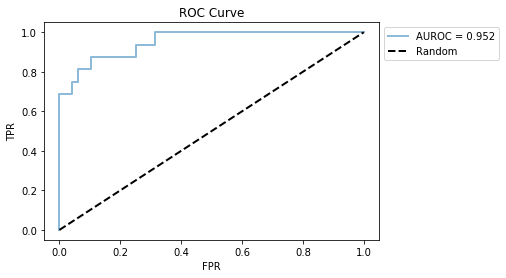

In [10]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auroc = auc(fpr, tpr)
plt.plot(fpr,tpr,label = 'AUROC = {:.3f}'.format(auroc), linewidth = 2, alpha = 0.5)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle = 'dashed', linewidth = 2, label = 'Random', color = 'k')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc = 0, bbox_to_anchor = (1, 1))
plt.show()

---
# Performance Evaluation (All Models)

In [11]:
vgg16 = np.loadtxt('preds/vgg16.txt', delimiter = ',')
vgg19 = np.loadtxt('preds/vgg19.txt', delimiter = ',')
inceptionv3 = np.loadtxt('preds/inceptionv3.txt', delimiter = ',')
resnet50v2 = np.loadtxt('preds/resnet50v2.txt', delimiter = ',')
resnet101v2 = np.loadtxt('preds/resnet101v2.txt', delimiter = ',')
vgg16_1stage = np.loadtxt('preds/vgg16_wholeonly.txt', delimiter = ',')

# models = ('VGG16 Satu Tahap', 'VGG16 Dua Tahap')
# preds = (vgg16_1stage, vgg16)

models = ('VGG16', 'VGG19', 'InceptionV3', 'ResNet50V2', 'ResNet101V2', 'VGG16 1 Stage')
preds = (vgg16, vgg19, inceptionv3, resnet50v2, resnet101v2, vgg16_1stage)

pred_conf_matrix, auroc, roc, preds_bin = [], [], [], []

def to_bin(y, threshold):
    y_bin = []
    for i in range(len(y)):
        if (y[i] > threshold):
            y_bin.append(1)
        else:
            y_bin.append(0)
    return y_bin

for pred in preds:
    roc.append(roc_curve(y_test, pred, drop_intermediate=False))
    auroc.append(auc(roc[-1][0], roc[-1][1]))
    optimal_idx = np.argmax(roc[-1][1] - roc[-1][0])
    optimal_threshold = roc[-1][2][optimal_idx]
    preds_bin.append(to_bin(pred, optimal_threshold-1e-6))
    pred_conf_matrix.append(confusion_matrix(y_test, preds_bin[-1]))

## ROC Curve

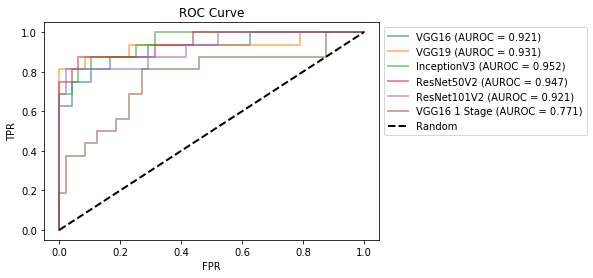

In [12]:
for i in range(len(roc)):
    plt.plot(roc[i][0],roc[i][1],label = models[i] + " (AUROC = {:.3f})".format(auroc[i]), linewidth = 2, alpha = 0.5)

plt.plot([0.0, 1.0], [0.0, 1.0], linestyle = 'dashed', linewidth = 2, label = 'Random', color = 'k')

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend(loc = 0, bbox_to_anchor = (1, 1))
plt.show()

## Confusion Matrix

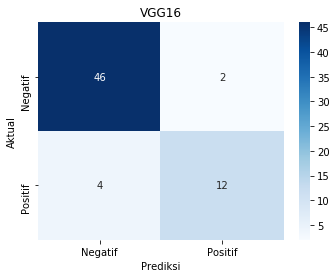

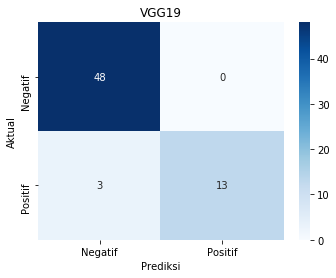

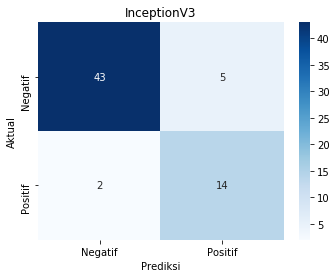

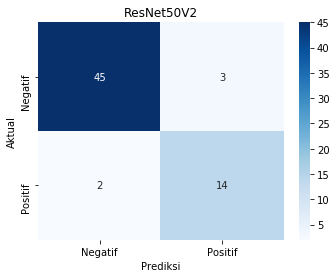

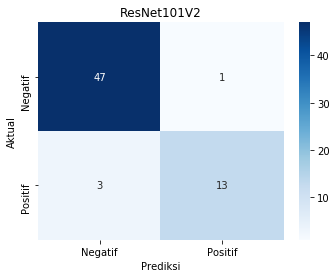

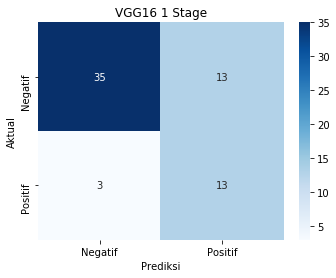

In [13]:
for i in range(len(pred_conf_matrix)):
    df_cm = pd.DataFrame(pred_conf_matrix[i], index = ['Negatif', 'Positif'],
                      columns = ['Negatif', 'Positif'])
    plt.figure(figsize = (5.5,4))
    sn.heatmap(df_cm, annot = True, cmap = 'Blues')

    plt.title(models[i])
    plt.ylabel('Aktual')
    plt.xlabel('Prediksi')
    plt.show()

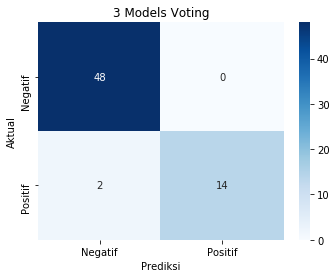

In [16]:
ensemble_voting = []
for i in range(len(y_test)):
    positive = 0
    negative = 0
    for j in range(1, 4):
        if(preds_bin[j][i] == 0):
            negative += 1
        else:
            positive += 1
    if(negative > positive):
        ensemble_voting.append(0)
    else:
        ensemble_voting.append(1)

ensemble_cm = confusion_matrix(y_test, ensemble_voting)

df_cm = pd.DataFrame(ensemble_cm, index = ['Negatif', 'Positif'],
                    columns = ['Negatif', 'Positif'])
plt.figure(figsize = (5.5,4))
sn.heatmap(df_cm, annot = True, cmap = 'Blues')

plt.title("3 Models Voting")
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()